<h3>  
<center> 
<b> Adnan Rashid </b><\h3>
<br><br>
<nav>
    <center>
    | <a href="00-Contents-Setup.ipynb"> Home Page </a> | 
    <a href="http://bit.ly/cka_notes_original"> Kubernetes Notes </a> |
    <a href="https://adnan.study"> Website </a> |
    <a href="https://www.instagram.com/adnans_techie_studies/"> Instagram </a> |
    <a href="https://www.linkedin.com/in/adnanrashid1/"> LinkedIn </a> |
</nav>

<h1 style="background:black"><code style="background:black;color:white"><center>Securing your Cluster with Network Policies</center></code></h1>

<div class="alert alert-block alert-warning">
<font style="color:black">
<center> 
    
We are going to use Project Calico to secure our cluster by using network policies and then integrating our cluster's policies with EKS security groups. 

Project Calico will be used to enforce Kubernetes network policies in our cluster, protecting our various microservices. 

* Network policies allow you to define rules that determine what type of traffic is allowed to flow between different services 

* Using network policies you can also define rules to restrict traffic. They are a means to imporve your cluster's security 

* Network policies help in isolating traffic within namespaces. 

If you have separate namespaces for development and production, you can prevent traffic flow between them by restrict pod to pod communication within the same namespace

<center><img src="https://adnanstudyimages.s3-eu-west-1.amazonaws.com/19.jpg" width=50% height=50% border=5/>

* Kubernetes Pod Networking on AWS 

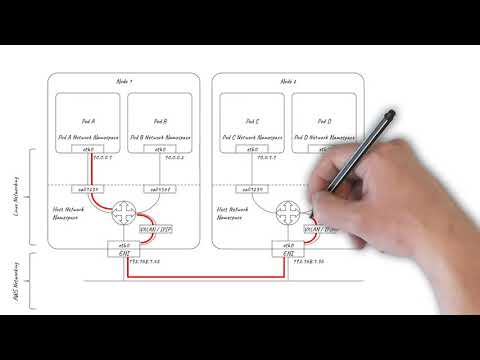

In [27]:
from IPython.display import YouTubeVideo
YouTubeVideo('7LRtytR6ZbA')

## Pre-requisite

* Check your variables are loaded

In [ ]:
%store

* Load in variable store

In [ ]:
%store -r 

* Load variables into notebook

In [ ]:
%env AWS_PROFILE=$AWS_PROFILE
%env AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION
%env ACCOUNT_ID=$ACCOUNT_ID

* Check identity 

In [ ]:
!aws sts get-caller-identity

<br>

---
---

## <br><br>Install Calico 

* Install Calico manifest which creates the daemon sets in the kube-system namespace

In [ ]:
!kubectl apply -f https://raw.githubusercontent.com/aws/amazon-vpc-cni-k8s/master/config/v1.6/calico.yaml

<div class="alert alert-block alert-success">
<font style="color:black">

Key features of the Calico manifest:<br>

<h4><b> Feature 1 </b></h4>
<blockquote>
    <ol>
<li>Annotations are a way to attach non-identifying metadata to objects. <br>
<li>This metadata is not used internally by Kubernetes, so they cannot be used to identify within k8s. Instead, they are used by external tools and libraries
    </ol>
</blockquote>
<br>
Examples of annotations include build/release timestamps, client library information for debugging or fields managed by a network policy like Calico in this case
<br><br>
In contrast, Labels in Kubernetes are intended to be used to specify identifying attributes for objects. 
<br><br>
Labels are used by selector queries or with label selectors. Since they are used internally by kubernetes the structure of keys and values is constrained, to optimise queries 
<br><br><br>
    
<h4><b> Feature 2 </b></h4>
<blockquote>
    <ol>
 <li>The manifest has a tolerations attribute.</li>
 <li>Taints and tolerations work together to ensure pods are not scheduled onto inappropriate nodes.</li>
 <li>Taints are applied to nodes, and the <b>only pods that can tolerate the taint are allowed to run on those nodes </b></li>
</ol>
</blockquote>

<br>
A taint consists of a key, a value for it and an effect, which can be

* <b>PreferNoSchedule:</b> Prefer not to schedule intolerant pods to the tained node 
* <b>NoSchedule:</b> Do not schedule intolerant pods to the tained node 
* <b>NoExecute:</b> In addition to not scheduling, also evict intolerant pods that are already running on the node 

Like taints, tolerations also have a key value pair and an effect, with the addition of operator. Here in the Calico manifest, we see tolerations has just one attribute: <b>Operator = exists. </b>

This means the key value pair is omitted and the toleration will match any taint, ensuring it runs on all nodes

* Watch the kube-system daemon sets and wait for the calico-node daemon set to have the DESIRED number of pods in the READY state

In [ ]:
!kubectl get daemonset calico-node --namespace=kube-system

## <br><br>Stars Policy Demo 

We create a frontend, backend, client and UI services on the EKS cluster and define network policies to allow or block communication between these services. This demo also has a management UI that shows the available ingress and egress paths between each service

#### Stars Namespace

* Before creating network policies, lets view the required resources 

In [ ]:
!cat calico_resources/namespace.yaml 

* Create namespace called 'stars'

In [ ]:
!kubectl apply -f calico_resources/namespace.yaml 

* Create a management-ui namespace, with a management-ui service and replication controller within that namespace

In [ ]:
!kubectl apply -f calico_resources/management-ui.yaml

* To see how the backend and front is built, you can cat the following files

In [ ]:
!cat calico_resources/backend.yaml

In [ ]:
!cat calico_resources/frontend.yaml

* Create frontend and backend replication controllers and services within the stars namespace

In [ ]:
!kubectl apply -f calico_resources/backend.yaml 
!kubectl apply -f calico_resources/frontend.yaml

* Here you can see how the client namespace, and a client service for a replication controller are built.

In [ ]:
!cat calico_resources/client.yaml

* Apply the client configuration

In [ ]:
!kubectl apply -f calico_resources/client.yaml

* Check their status, and wait for all the pods to reach the Running status. 

In [ ]:
!kubectl get pods --all-namespaces

#### <br><br>Summary 

* A namespace called stars 
* frontend and backend replication controlers and services within stars namespace 
* A namespace called management-ui 
* Replication controller and service management-ui for the user interface seen on the browser, in the management-ui namespace 
* A namespace called client 
* client replication controller and service in client namespace 

## <br><br>Default Pod-to-Pod Communication

In Kubernetes, the <b>pods by default can communicate with other pods</b>, regardless of which host they land on 

* Every pod gets its own IP address so you do not need to explicitly create links between pods 

This is demonstrated by the <b>management-ui</b>

* To open the management UI, retrieve the DNS name of the Management UI 

In [ ]:
!kubectl get svc -o wide -n management-ui 

* Copy the <b> EXTERNAL-IP</b> from the output above and paste into browser
* The EXTERNAL-IP column contains a value that ends with 'elb.amazonaws.com' - the full value is the DNS address 

The UI here shows the default behavior, of all services being able to reach each other. 

<img src="https://www.eksworkshop.com/images/calico-full-access.png" width="40%" height="40%"/>

## <br><br>Apply Network Policies

In production level cluster, it is not secure to have open pod to pod communication. Lets see how we can isolate the services from each other 

In [ ]:
cat calico_resources/default-deny.yaml

Here we see the podSelector does not have any matchLabels, essentially blocking all the pods from accessing it 

* Apply the network policy in the <b>stars</b> namespace (frontend and backend services) and the <b>client</b> namespace (client service) 

In [ ]:
!kubectl apply -n stars -f calico_resources/default-deny.yaml 
!kubectl apply -n client -f calico_resources/default-deny.yaml

<blockquote><br>If you refresh the browser now, you will see that nothing shows up on the UI

- Network policies in Kubernetes use labels to select pods, and define rules on what traffic is allowed to reach those pods. 
- They may specify ingress or egress or both
- Each rule allows traffic which matches both the from and ports section 

* Create two new network policies and check the contents

In [ ]:
cat calico_resources/allow-ui.yaml

In [ ]:
cat calico_resources/allow-ui-client.yaml

* Apply our network policies to allow the traffic we want

In [ ]:
!kubectl apply -f calico_resources/allow-ui.yaml 
!kubectl apply -f calico_resources/allow-ui-client.yaml 

* This time you can see the management UI can reach the services the they cannot communicate with each other 

<img src="https://www.eksworkshop.com/images/calico-mgmtui-access.png" width="40%" height="40%"/>

## <br><br>Allow Directional Traffic 

* Lets see how we can allow directional traffic from client to frontend, and from frontend to backend
* Lets examine this backend policy first

In [ ]:
cat calico_resources/backend-policy.yaml 

* Allow traffic from frontend service to the backend service apply the manifest 

In [ ]:
!kubectl apply -f calico_resources/backend-policy.yaml 
!kubectl apply -f calico_resources/frontend-policy.yaml 

<img src="https://www.eksworkshop.com/images/calico-client-f-b-access.png" width="40%" height="40%"/>

* The backend policy has a podSelector that selects all pods with the label <b>role:backend</b>, and allows ingress from all pods that have the label <b>role:frontend</b> and on TCP port 6379, but not the other way round. 
* Traffic is allowed in one direction on a specific port number

* The frontend-policy is similar, except it allows ingress from namespaces that have the label <b>role: client</b> on TCP port <b>80 </b>

## <br><br>Cleanup

In [ ]:
!kubectl delete namespace client stars management-ui

In [ ]:
!kubectl delete -f https://raw.githubusercontent.com/aws/amazon-vpc-cni-k8s/master/config/v1.6/calico.yaml